# Perform Inversion for the Greenland traction: 
## <font color=blue>"inversion.ipynb"</font>
#### Dec 02, 2022  <font color=red>(v. testing)</font>
##### Aryan Jain 

1. The G-matrix will be loaded from a file created in the previous step
2. A Least Square Method will be used to find the best coefficients of the basis functions
3. The goal is to find the best linear combination of the basis functions that predicted the data 

In [60]:
# Import modules
import numpy as np
import pandas as pd
import scipy 
import sys
import os
from sklearn import linear_model  
import matplotlib.pyplot as plt

In [63]:
# Create directory where all the results will be saved.
parent_dir = os.getcwd()
directory = "inver_results_cm"
path = os.path.join(parent_dir, directory)
try:
    os.mkdir(path)
    print("Directory '%s' created successfully" % directory)
except:
    print("Directory '%s' already exists " % directory)

Directory 'inver_results_cm' already exists 


In [61]:
# CHOOSE THE TYPE OF LSMs

inversion_flag = 3
# inversion_flag = sys.argv[1]
# inversion_flag = float(inversion_flag)

# 1 is simple LSM
# 2 is Pseudo LSM 
# 3 is Damped LSM (Tikhonov Regularization Least Squares = Ridge reg.)
# 4 is Damped LSM (LASSO Regression using Scikit-learn modules)

In [62]:
# If you choose to run a Damped LSM, you must define the
# smoothing parameters (alpha values).
smoothing_params = np.logspace(-2,2,100)
smoothing_params

array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.05385551e-02, 3.35160265e-02, 3.67837977e-02, 4.03701726e-02,
       4.43062146e-02, 4.86260158e-02, 5.33669923e-02, 5.85702082e-02,
       6.42807312e-02, 7.05480231e-02, 7.74263683e-02, 8.49753436e-02,
       9.32603347e-02, 1.02353102e-01, 1.12332403e-01, 1.23284674e-01,
       1.35304777e-01, 1.48496826e-01, 1.62975083e-01, 1.78864953e-01,
       1.96304065e-01, 2.15443469e-01, 2.36448941e-01, 2.59502421e-01,
       2.84803587e-01, 3.12571585e-01, 3.43046929e-01, 3.76493581e-01,
       4.13201240e-01, 4.53487851e-01, 4.97702356e-01, 5.46227722e-01,
       5.99484250e-01, 6.57933225e-01, 7.22080902e-01, 7.92482898e-01,
       8.69749003e-01, 9.54548457e-01, 1.04761575e+00, 1.14975700e+00,
       1.26185688e+00, 1.38488637e+00, 1.51991108e+00, 1.66810054e+00,
      

In [64]:
# Output files
outputFILE_model_prefix="model_coef_" # Model Coefficients
outputFILE_velocity_prefix="vel_pred_" # Surface Horizontal Velocity Field
outputFILE_velocity_InSAR_minus_GPE="vel_data.gmt"

# `STEP 1:` **BUILD a data vector,  $\vec{d}$**

In [49]:
# Load input files

names = ['lon','lat','ve','vn','se','sn','corr']


# 1. Velocity (InSAR)
input_vel_InSAR = "vel_obs_m_per_hr.gmt"  # Interpolated InSAR Velocity [m/hr]
df_vel_InSAR = pd.read_csv(input_vel_InSAR,header=None, sep=r'(?:,|\s+)', comment='#', engine='python')
df_vel_InSAR.columns = names


# 2. Velocity (GPE)
input_vel_GPE = "vel_gpe.gmt"  # GPE-associated effective Velocity [m/hr]
df_vel_GPE = pd.read_csv(input_vel_GPE,header=None, sep=r'(?:,|\s+)', comment='#', engine='python')
df_vel_GPE.columns = names

In [50]:
# 3. data = (Velocity InSAR - Velocity GPE)
# BUILD the data vector along with coordinate information.
# The x-component values are first and then the y-component values.


### Process InSAR velocity 

df_vel_x_InSAR = df_vel_InSAR.iloc[:,[0,1,2]]  # saved vx data (InSAR)
df_vel_y_InSAR = df_vel_InSAR.iloc[:,[0,1,3]]  # saved vn data (InSAR)
df_vel_x_InSAR=df_vel_x_InSAR.rename(columns ={'ve': 'data'}) #column name change
df_vel_y_InSAR=df_vel_y_InSAR.rename(columns ={'vn': 'data'}) #column name change

# !! SORT VALUES !! # lat (ascending) first, and then lon (ascending).
# This step is very important: The rows of the data vector, d, must be
# corresponding to the rows of the G matrix.
# i.e., each row in both d and G must have the same coordinates.
df_vel_x_InSAR = df_vel_x_InSAR.sort_values(['lat', 'lon'], ascending=[True, True])
df_vel_y_InSAR = df_vel_y_InSAR.sort_values(['lat', 'lon'], ascending=[True, True])

# MERGE two columns (n*2) into a column (2n*1)
# > ignore_index = True : 
# >   have one continuous index numbers,
# >     ignorning each of the two dfs original indices
framesInSAR = [df_vel_x_InSAR,df_vel_y_InSAR]
df_data_InSAR_all = pd.concat(framesInSAR,ignore_index=True) # merge the two dataFrames into one

# SAVE GNSS velocity separately
df_data_InSAR = df_data_InSAR_all.loc[:,['data']]



### Process GPE velocity 

df_vel_x_GPE = df_vel_GPE.iloc[:,[0,1,2]]  # saved vx data (GPE-associated velocity)
df_vel_y_GPE = df_vel_GPE.iloc[:,[0,1,3]]  # saved vn data (GPE-associated velocity)
df_vel_x_GPE=df_vel_x_GPE.rename(columns ={'ve': 'data'}) #column name change
df_vel_y_GPE=df_vel_y_GPE.rename(columns ={'vn': 'data'}) #column name change

# !! SORT VALUES !! # lat (ascending) first, and then lon (ascending).
# This step is very important: The rows of the data vector, d, must be
# corresponding to the rows of the G matrix.
# i.e., each row in both d and G must have the same coordinates.
df_vel_x_GPE = df_vel_x_GPE.sort_values(['lat', 'lon'], ascending=[True, True])
df_vel_y_GPE = df_vel_y_GPE.sort_values(['lat', 'lon'], ascending=[True, True])

# MERGE two columns (n*2) into a column (2n*1)
# > ignore_index = True : 
# >   have one continuous index numbers,
# >     ignorning each of the two dfs original indices
framesGPE = [df_vel_x_GPE,df_vel_y_GPE]
df_data_GPE_all = pd.concat(framesGPE,ignore_index=True) # merge the two dataFrames into one

# SAVE GNSS velocity separately
df_data_GPE = df_data_GPE_all.loc[:,['data']]



### Subtraction
df_data_total = df_data_InSAR - df_data_GPE

### SAVE (velocityInSAR - velocityGPE)
df_velo_InSAR_minus_GPE = df_vel_InSAR

df_velo_InSAR_minus_GPE['ve'] = df_data_total[:int(len(df_data_total)/2)].reset_index(drop=True)

df_velo_InSAR_minus_GPE['vn'] = df_data_total[int(len(df_data_total)/2):].reset_index(drop=True)

df_velo_InSAR_minus_GPE.to_csv(outputFILE_velocity_InSAR_minus_GPE, header=None, index=None, sep=' ', float_format='%g')

# `STEP 2:` **Load G-Matrix, $\bar{\bar{G}}$**

In [51]:
Gmatrix_file="G_matrix.out"
df_G_final=pd.read_csv(Gmatrix_file, sep = ',')

In [52]:
if len(df_data_total)!=len(df_G_final):
    print("WARNING: Something went wrong!")

<div class="alert alert-success">
<b>NOTE: If you don't see WARNING, go ahead and run the inversion. </b> 
</div>

# `STEP 3:` RUN Inversion (LSM)
> G-matrix = **df_G_final** \
> data vec = **df_data_total**

In [53]:
# # Build a Diagonal Weighting Matrix W.
# nTotal=len(df_data_total)

# # STD of the data
# error = np.ones(nTotal) #replace 1s with std values if you have measurement uncertainties.
# errorTotalinv = 1/error
# W = np.diag(errorTotalinv)

# # convert into a dataframe
# dfW = pd.DataFrame(W)

# # When calculating predictions, the non-weighted G-matrix is needed. Save it.
df_G_final_save = df_G_final

# # When calculating the misfit, the non-weighted data is needed. Save it.
df_data_total_save = df_data_total

# # Multiply the Diagonal Weighting Matrix dfW to the data vector and Gmatrix
# df_G_final = dfW @ df_G_final_save
# df_data_total = dfW @ df_data_total_save


<div class="alert alert-warning">
    <div class="alert--icon"> <i class="far fa-times-circle"></i> </div>
    <p> The cell block above won't be used for this inversion. </p>
    <b> You can modify this cell if you want to incorpolate data uncertainties. </b>
</div>

In [54]:
# Define some values before you run an inversion

nTotal=len(df_data_total)
# How Many Basis Functions 
HowManyBasisFunctions=np.loadtxt("geometry_info.txt", skiprows=1)
HowManyCell=int(HowManyBasisFunctions[1])

df_G_prime = df_G_final.transpose() 

# G'G
# >Two different ways to compute a matrix multiplication
    # >1st method
GpG1=df_G_prime.dot(df_G_final) #G'G
    # >2nd method
GpG2=df_G_prime @ df_G_final #G'G
    # >These results are same.
    # >Let's take the second one as G'G
GpG = GpG2 #GpG is G'G


df_vel_save = df_vel_y_InSAR.iloc[:,[0,1]]

In [58]:
# Define a saving function

def saving_results(df_vel_save, df_data_total_save, df_G_final_save, df_best_model, inversion_flag, path, mult_str, alpha):
    
    # data prediction
    df_data_predicted = df_G_final_save @ df_best_model

    # predicted velocity 
    n_data_predicted = len(df_data_predicted)

    #velocity predicted x
    df_prediction_x=df_data_predicted.iloc[0:int(n_data_predicted/2)] 
    df_prediction_x=df_prediction_x.reset_index(drop=True)
    #velocity predicted y
    df_prediction_y=df_data_predicted.iloc[int(n_data_predicted/2):n_data_predicted] 
    df_prediction_y=df_prediction_y.reset_index(drop=True)

    
    df_vel_save['vx'] = df_prediction_x
    df_vel_save['vn'] = df_prediction_y
    df_vel_save['se'] = np.zeros(int(n_data_predicted/2))
    df_vel_save['sn'] = np.zeros(int(n_data_predicted/2))
    df_vel_save['corr'] = np.zeros(int(n_data_predicted/2))
    
    if inversion_flag == 1:
        inv_type = "Simple_LSM_"
    elif inversion_flag == 2:
        inv_type = "Moore_Penrose_"
    elif inversion_flag == 3: 
        inv_type = "Ridge_"
        norm_type = 2
    elif inversion_flag == 4:
        inv_type = "LASSO_"
        norm_type = 1


    if alpha == 0:
        df_vel_save.to_csv(path+"/"+outputFILE_velocity_prefix+inv_type+".gmt", header=None, index=None, sep=' ', float_format='%g')
        df_best_model.to_csv(path+"/"+outputFILE_model_prefix+inv_type+".out", header=None, index=None, float_format='%g')
    else:
        alpha_str = str(alpha)
        df_vel_save.to_csv(path+"/"+outputFILE_velocity_prefix+inv_type+alpha_str+"_"+mult_str+".gmt", header=None, index=None, sep=' ', float_format='%g')
        df_best_model.to_csv(path+"/"+outputFILE_model_prefix+inv_type+alpha_str+"_"+mult_str+".out", header=None, index=None, float_format='%g')  
 

    # squared norm2 misfit 
    df_norm2=(df_data_total_save.to_numpy()-df_data_predicted.to_numpy())**2
    misfit_norm2=df_norm2.sum()
    
    # squared norm2 model 
    model_norm2 = np.linalg.norm(df_best_model,norm_type)**2
    
    return misfit_norm2, model_norm2

In [65]:
# Run Inversion

###############################
## inv(G'G)*G'*d = model(LSM) #
###############################


if inversion_flag == 1:
    #  1st method: np.linalg.inv
    print("A simple LSM will be performed.")
    df_inv_GpG = pd.DataFrame(np.linalg.inv(GpG.to_numpy()), GpG.columns, GpG.index)
    df_best_model=df_inv_GpG@df_G_prime@df_data_total #inversion
    
    misfit_norm2, model_norm2 = saving_results(df_vel_save, df_data_total_save, df_G_final_save, df_best_model, inversion_flag, path, alpha = 0)
    
elif inversion_flag == 2:
    #  2nd method: np.linalg.pinv (Moore-Penrose inverse (SVD))
    print("A simple Moore-Penrose LSM will be performed.")
    df_pinv_GpG = pd.DataFrame(np.linalg.pinv(GpG.to_numpy()), GpG.columns, GpG.index)
    df_best_model=df_pinv_GpG@df_G_prime@df_data_total #pseudo inversion

    misfit_norm2, model_norm2 = saving_results(df_vel_save, df_data_total_save, df_G_final_save, df_best_model, inversion_flag, path, alpha = 0)
    
    
else: 
    
    if inversion_flag == 3:
        print("Ridge Regression Will Be Performed.")
    if inversion_flag == 4:
        print("LASSO Regression Will Be Performed.")
        
    Ninv = 0
    misfit_norm2_list = []
    model_norm2_list = []
    alpha = 0.1519911082952933

    for multiplier in range(100, 90, -1):
        # Ninv_total = len(smoothing_params)
        # Ninv = Ninv + 1
        # print("[%3i/%3i] Your smoothing parameter, alpha, is %7.2f.   Inversion is running..." % (Ninv,Ninv_total,alpha))
        
        if inversion_flag == 3:       
            #  3rd method: Ridge Regression (Tikhonov Regularization)
            alp=(alpha**2)*np.ones((HowManyCell*3,))
            damping_matrix=np.diag(alp) # (a**2)*I    
            GpG_damping = GpG + damping_matrix #(G'G + a*a*I)
            GpD=df_G_prime@df_data_total
            df_model_damping= np.linalg.solve(GpG_damping,GpD)
            df_best_model=pd.DataFrame(df_model_damping[:,0])
            df_best_model.index=df_G_final_save.columns.values

            df_best_model = df_best_model * (multiplier/100)
            mult_str = str((multiplier/100))
        
            misfit_norm2, model_norm2 = saving_results(df_vel_save, df_data_total_save, df_G_final_save, df_best_model, inversion_flag, path, mult_str, alpha = alpha)
            misfit_norm2_list.append(misfit_norm2)
            model_norm2_list.append(model_norm2)
                
            # elif inversion_flag == 4: 
            #     #  4th method [Testing]: scikit-learn LASSO (L1-norm)
                
            #     df_pinv_GpG = pd.DataFrame(np.linalg.pinv(GpG.to_numpy()), GpG.columns, GpG.index)
            #     df_best_model=df_pinv_GpG@df_G_prime@df_data_total  
            #     np_G_final = df_G_final.to_numpy()
            #     np_data_total= df_data_total.to_numpy()
            #     np_data_total = np.squeeze(np_data_total)
                
            #     clf = linear_model.Lasso(alpha=alpha)
            #     clf.fit(np_G_final, np_data_total)
            #     s_L1 = clf.coef_
            #     a=s_L1.reshape(len(s_L1),1)
            #     df_best_model.loc[:,['data']]=a

            #     misfit_norm2, model_norm2 = saving_results(df_vel_save, df_data_total_save, df_G_final_save, df_best_model, inversion_flag, path, alpha = alpha, multiplier)
            #     misfit_norm2_list.append(misfit_norm2)
            #     model_norm2_list.append(model_norm2)


    # for alpha in smoothing_params:
    #     Ninv_total = len(smoothing_params)
    #     Ninv = Ninv + 1
    #     print("[%3i/%3i] Your smoothing parameter, alpha, is %7.2f.   Inversion is running..." % (Ninv,Ninv_total,alpha))
        
    #     if inversion_flag == 3:       
    #         #  3rd method: Ridge Regression (Tikhonov Regularization)
            
    #         # alp=(alpha**2)*np.ones((HowManyCell*3,))
    #         alpha = 0.015922827933410922

    #         damping_matrix=np.diag(alp) # (a**2)*I    
    #         GpG_damping = GpG + damping_matrix #(G'G + a*a*I)
    #         GpD=df_G_prime@df_data_total
    #         df_model_damping= np.linalg.solve(GpG_damping,GpD)
    #         df_best_model=pd.DataFrame(df_model_damping[:,0])
    #         df_best_model.index=df_G_final_save.columns.values
        
    #         misfit_norm2, model_norm2 = saving_results(df_vel_save, df_data_total_save, df_G_final_save, df_best_model, inversion_flag, path, alpha = alpha, multiplier)
    #         misfit_norm2_list.append(misfit_norm2)
    #         model_norm2_list.append(model_norm2)
            
    #     elif inversion_flag == 4: 
    #         #  4th method [Testing]: scikit-learn LASSO (L1-norm)
             
    #         df_pinv_GpG = pd.DataFrame(np.linalg.pinv(GpG.to_numpy()), GpG.columns, GpG.index)
    #         df_best_model=df_pinv_GpG@df_G_prime@df_data_total  
    #         np_G_final = df_G_final.to_numpy()
    #         np_data_total= df_data_total.to_numpy()
    #         np_data_total = np.squeeze(np_data_total)
            
    #         clf = linear_model.Lasso(alpha=alpha)
    #         clf.fit(np_G_final, np_data_total)
    #         s_L1 = clf.coef_
    #         a=s_L1.reshape(len(s_L1),1)
    #         df_best_model.loc[:,['data']]=a

    #         misfit_norm2, model_norm2 = saving_results(df_vel_save, df_data_total_save, df_G_final_save, df_best_model, inversion_flag, path, alpha = alpha)
    #         misfit_norm2_list.append(misfit_norm2)
    #         model_norm2_list.append(model_norm2)

Ridge Regression Will Be Performed.


In [66]:
# df_best_ridge = pd.read_csv('./Inversion_results/model_coef_Ridge_0.34760191815419783.out', header=None)


<div class="alert alert-success">
    <b> Inversion is done. Let's plot the trade-off curve (so-called "L-curve") </b>
</div>

# `STEP 4:` Plot a L-curve if a regularized inversion was run.

In [67]:
idx_best=-80
best_smoothing = smoothing_params[idx_best]
print("The best alpha value is %f." % best_smoothing)

The best alpha value is 0.064281.


Text(0.5, 1.0, 'The trade-off curve')

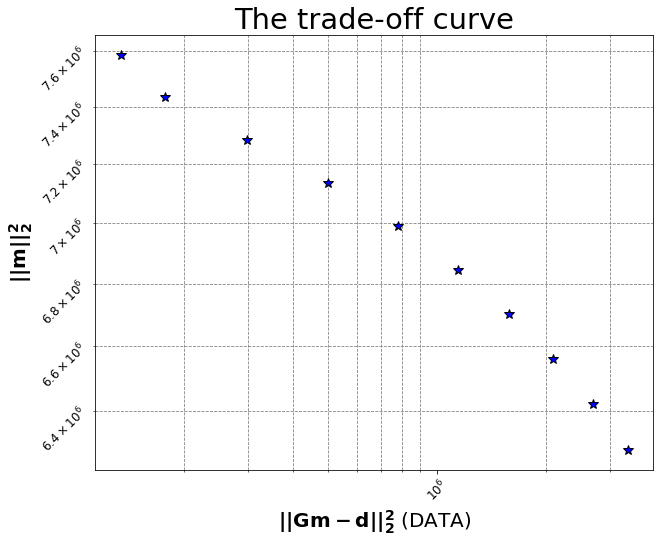

In [68]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(misfit_norm2_list, model_norm2_list, '*', markersize=10, markeredgecolor='black',markerfacecolor='b')
ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_xlim([10**7,10**8.5])
# ax.set_ylim([10**6,10**7])


ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$ (DATA)', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both')


ax.set_title("The trade-off curve", fontsize=29)

IndexError: list index out of range

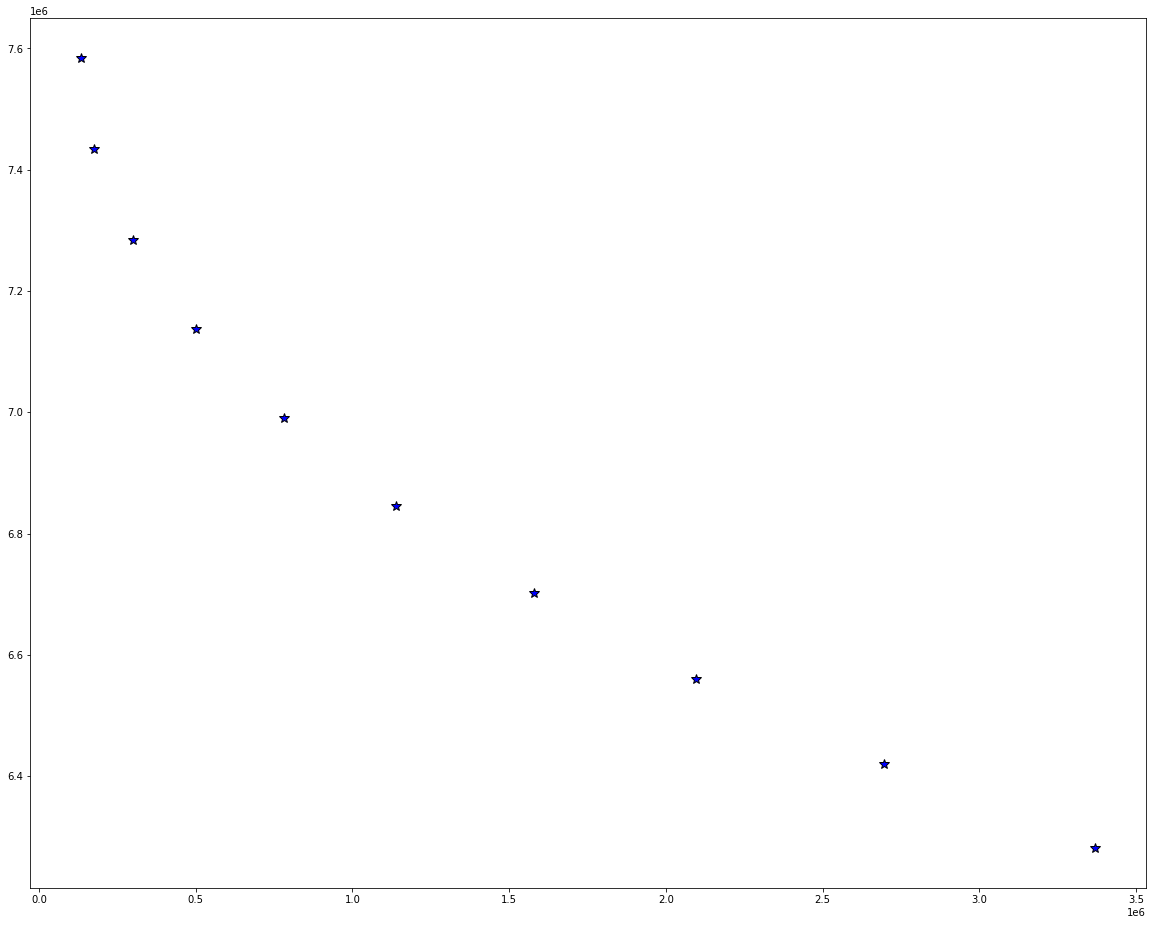

In [69]:
fig, ax = plt.subplots(figsize=(20,16))

ax.plot(misfit_norm2_list, model_norm2_list, '*', markersize=10, markeredgecolor='black',markerfacecolor='b')
ax.plot(misfit_norm2_list[idx_best], model_norm2_list[idx_best], 'o', markersize=15, markeredgecolor='red',markerfacecolor='red',alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_xlim([10**7,10**8.5])
# ax.set_ylim([10**6,10**8])

smoothing_params[-17]
ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$ (DATA)', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both')


ax.set_title("The trade-off curve", fontsize=29)

Text(0.5, 0, 'Basis Functions')

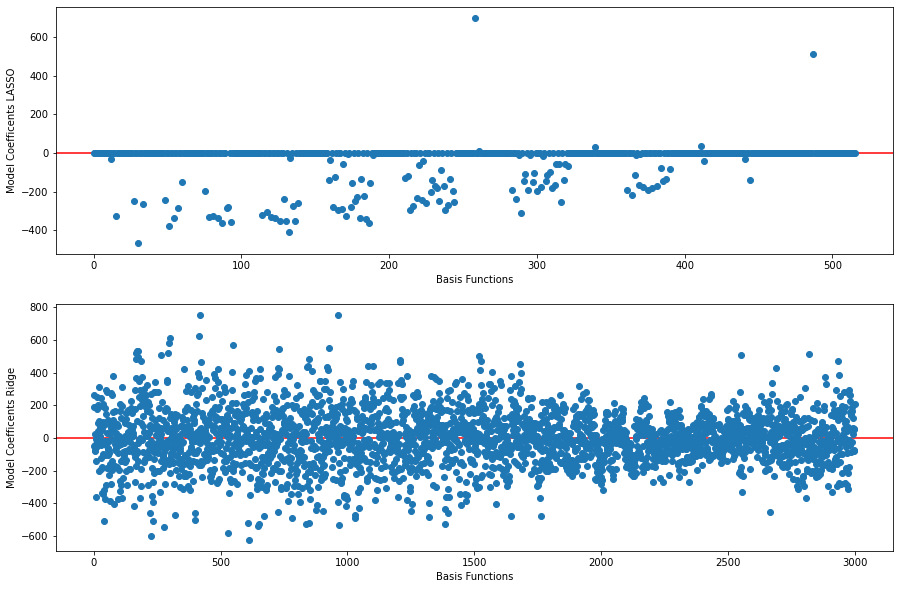

In [ ]:
#LASSO - 0.064281.
#Ridge - 0.347602.

df_LASSO = pd.read_csv('./Inversion_results_New\model_coef_LASSO_0.3831186849557285.out', header=None)
df_ridge = pd.read_csv('./Inversion_results_nm\model_coef_Ridge_0.015922827933410922.out', header=None)

# print(df)
# inversion_gl_new_new\Inversion_results\model_coef_LASSO_6.46167078746697.out
# inversion_changing_magnitudes\Inversion_results_New\model_coef_LASSO_0.3831186849557285.out
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
ax1.axhline(y=0, color='r', linestyle='-')
ax1.plot(df_LASSO, 'o')
ax1.set_ylabel("Model Coefficents LASSO")
ax1.set_xlabel("Basis Functions")
ax2.axhline(y=0, color='r', linestyle='-')
ax2.plot(df_ridge, 'o')
ax2.set_ylabel("Model Coefficents Ridge")
ax2.set_xlabel("Basis Functions")

# print()

In [ ]:
print(df_ridge)

             0
0     192.2020
1     261.4800
2     -49.8322
3     -41.7735
4     -79.1736
...        ...
2995   56.5135
2996  -78.4853
2997   57.7207
2998  -70.6984
2999  209.6860

[3000 rows x 1 columns]


In [ ]:
df_ridge_scale = df_ridge * .98
print(df_ridge_scale)

               0
0     188.357960
1     256.250400
2     -48.835556
3     -40.938030
4     -77.590128
...          ...
2995   55.383230
2996  -76.915594
2997   56.566286
2998  -69.284432
2999  205.492280

[3000 rows x 1 columns]


In [ ]:
for multiplier in range(100, 90, -1):
    df_ridge_new = df_ridge * (multiplier/100)
    df_ridge_new.to_csv("./inversion_results_ridge_changing_magnitudes/model_coef_Ridge_0.015922827933410922_"+str(multiplier/100)+".out", header=None, index=None, float_format='%g')

In [ ]:
df_ridge_new = pd.read_csv('./inversion_results_ridge_changing_magnitudes\model_coef_Ridge_0.015922827933410922_0.91.out', header=None)
print(df_ridge_new)
print(df_ridge)

             0
0     174.9040
1     237.9470
2     -45.3473
3     -38.0139
4     -72.0480
...        ...
2995   51.4273
2996  -71.4216
2997   52.5258
2998  -64.3355
2999  190.8140

[3000 rows x 1 columns]
             0
0     192.2020
1     261.4800
2     -49.8322
3     -41.7735
4     -79.1736
...        ...
2995   56.5135
2996  -78.4853
2997   57.7207
2998  -70.6984
2999  209.6860

[3000 rows x 1 columns]
